# Projet 3 : Anticipez les besoins en consommation électrique de batiments  
# Notebook de tests d'apprentissages
Ce notebook contient les différents essais de modèles d'apprentissage.


## Contexte et objectifs :  
La ville de Seattle a effectué des relevés de consommation énergétique et des émissions des gaz à effet de serres des batiments de la ville.  
Cependant ces relevés sont très couteux et donc la ville voudrait prédire ces valeurs pour les batiments dont les mesures ne sont pas disponibles.  
Le but est donc de prédire la consommation énergétique et les émissions de GES des batiments de la ville.  
Pour réaliser cette prédiction, on pourra se baser sur les données du permis d'exploitation, afin d'éviter tout relevés.  
De plus, la ville voudrait connaitre l'apport de l'Energy Star Score dans cette prédiction. En effet, cette variable est fastidieuse à calculer et donc on voudrait savoir si cette information apporte une plus value ou non dans la prédiction.

## Chargement des modules Python

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import model_selection, dummy, linear_model, neighbors, svm, tree, metrics, neural_network, ensemble, kernel_ridge
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from scipy.stats import pearsonr

## fonctions utiles

In [2]:
class My_preprocessing :
    """
    Class to perform the preprocessing of the dataset
    """
    def __init__(self, binary_cols=[], float_cols=[], prct_cols=[], norm="no") :
        self.binary_cols = binary_cols
        self.float_cols = float_cols
        self.prct_cols = prct_cols
        if norm in ['std', 'log', 'no'] :
            self.type = norm
        else :
            print("Warning, wrong normalisation type")
            self.type = "no"
        if norm == "std" :
            self.func_float = StandardScaler()
        else :
            self.func_float = self.nothing()
        self.func_prct = self.prct2int
        self.is_fitted = False
        
    def prct2int(self, data) :
        """
        method to convert percentage in range 0, 100 to range 0,1
        parameters : np.array like 
        returns : np.array-like
        """
        return data/100
    
    def logscaler(self, data):
        """
        method to convert convert into log scale
        parameters : np.array like 
        returns : np.array-like
        """
        return np.log10(data+1)
    
    def nothing(self) :
        """
        function nothing
        """
        pass
    
    def fit(self, data) :
        """
        function to fit the preprocessing parameters
        parameters : data np.array like
        returns : None
        """
        if self.type == "std" :
            self.func_float.fit(data[self.float_cols])
        self.is_fitted = True
        """
        function to fit the preprocessing parameters
        parameters : data np.array like
        returns : None
        """
    def transform(self, data) :
        """
        function to transform dataset
        parameters : data np.array like
        returns : np.array like
        """
        if self.is_fitted :
            odata = data.copy(deep=True)
            if self.type == 'log' :
                odata[self.float_cols] = self.logscaler(data[self.float_cols])
            elif self.type == "std":
                odata[self.float_cols] = self.func_float.transform(data[self.float_cols])
            odata[self.prct_cols] = self.func_prct(data[self.prct_cols])
            return odata.values
        else :
            raise "Preprocessor is not fitted"

## Variables globales
on créé un dataframe regroupant les scores des différents modéles

In [3]:
# stockage des résultats
result_NRJ = pd.DataFrame(columns=["model", "scaler","EnergySoreStar",'mean_score', "std", "result_obj", "level"])
result_GES = pd.DataFrame(columns=["model", "scaler", "EnergySoreStar",'mean_score', "std", "result_obj", "level"])

# pour le plot
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

## Chargement du dataset
On charge les données nettoyées dans le notebook de nettoyage.  
On utilise dans un premier temps le jeu de données avec la variable ENERGYSTARScore. En effet, pour pouvoir caractériser sans biais l'impact de cette variable, il est important d'utiliser le même dataset.  
Dans un second temps, nous pourrons comparer ce jeu de données avec le second contenant plus de données. 

In [4]:
DATA = pd.read_csv("data/building-energy-benchmarking_EnergyStarScore_cleaned.csv")
DATA.head()

,OSEBuildingID,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,...,Multifamily HR (10+),Multifamily LR (1-4),Multifamily MR (5-9),NonResidential,Nonresidential COS,SPS-District K-12,MainEnergySource_Electricity(%),MainEnergySource_NaturalGas(%),MainEnergySource_SteamUse(%),building_age
0,1,Hotel,1.0,12.0,88434,0.0,88434.0,Hotel,88434.0,65.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,88
1,2,Hotel,1.0,11.0,103566,15064.0,88502.0,Hotel,83880.0,51.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,19
2,3,Hotel,1.0,41.0,961990,0.0,961990.0,Hotel,757243.0,18.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,46
3,5,Hotel,1.0,10.0,61320,0.0,61320.0,Hotel,61320.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,89
4,10,Hotel,1.0,11.0,83008,0.0,83008.0,Hotel,81352.0,25.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,89


## Création du train test et test set
On sépare le jeu de données en 80% train et 20% test.  
On supprime les variables inutiles avant : 
- 'OSEBuildingID' : l'ID ne contient pas d'informations sur la consommation
- 'PrimaryPropertyType' : a été encodé en OneHot
- 'LargestPropertyUseType': a été encodé
- 'LargestPropertyUseTypeGFA' : a été encodé
- 'SteamUse(kBtu)' : nécessite un relevé, on utilise plutot le mix énergétique
- 'Electricity(kBtu)' nécessite un relevé, on utilise plutot le mix énergétique
- 'NaturalGas(kBtu)'nécessite un relevé, on utilise plutot le mix énergétique
- 'OtherFuelUse(kBtu)' nécessite un relevé, on utilise plutot le mix énergétique

In [5]:
Y = DATA[["SiteEnergyUseWN(kBtu)", "GHGEmissions(MetricTonsCO2e)"]]
X = DATA.drop(["SiteEnergyUseWN(kBtu)", "GHGEmissions(MetricTonsCO2e)", 'OSEBuildingID', 'PrimaryPropertyType',\
              'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)', \
               'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)' ], axis=1,inplace=False)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
y_train_NRJ = Y_train["SiteEnergyUseWN(kBtu)"].values
y_train_GES = Y_train["GHGEmissions(MetricTonsCO2e)"].values
y_test_NRJ = Y_test["SiteEnergyUseWN(kBtu)"].values
y_test_GES = Y_test["GHGEmissions(MetricTonsCO2e)"].values
print(f"Nombre d'observation dans le train set {len(X_train)}")
print(f"Nombre d'observation dans le test set {len(X_test)}")

Nombre d'observation dans le train set 3485
Nombre d'observation dans le test set 872


## Baseline
### retournant la moyenne

In [6]:
print("="*50)
print("Consommation d'énergie")
print("="*50)
model_NRJ= dummy.DummyRegressor(strategy="mean")
model_NRJ.fit(X_train, y_train_NRJ)
MAE_mean_NRJ = metrics.mean_absolute_error(y_train_NRJ, model_NRJ.predict(X_train))
print(f"Dummy mean : MAE = {MAE_mean_NRJ}")

print("="*50)
print("Emissions de GES")
print("="*50)
model_GES= dummy.DummyRegressor(strategy="mean")
model_GES.fit(X_train, y_train_GES)
MAE_mean_GES = metrics.mean_absolute_error(y_train_GES, model_GES.predict(X_train))
print(f"Dummy mean : MAE = {MAE_mean_GES}")

Consommation d'énergie
Dummy mean : MAE = 4577332.189132216
Emissions de GES
Dummy mean : MAE = 98.86887343132794


## retourant la médiane

In [7]:
print("="*50)
print("Consommation d'énergie")
print("="*50)
model_NRJ= dummy.DummyRegressor(strategy="median")
model_NRJ.fit(X_train, y_train_NRJ)
MAE_med_NRJ = metrics.mean_absolute_error(y_train_NRJ, model_NRJ.predict(X_train))
print(f"Dummy mean : MAE = {MAE_med_NRJ}")

print("="*50)
print("Emissions de GES")
print("="*50)
model_GES= dummy.DummyRegressor(strategy="median")
model_GES.fit(X_train, y_train_GES)
MAE_med_GES = metrics.mean_absolute_error(y_train_GES, model_GES.predict(X_train))
print(f"Dummy mean : MAE = {MAE_med_GES}")

Consommation d'énergie
Dummy mean : MAE = 3609291.83210897
Emissions de GES
Dummy mean : MAE = 79.55800286944046


## Classification des variables
Pour plus de simplicité dans la suite du code, on va classer l'ensemble des variables en différents groupes en fonction du type des valeurs : 
- binaire
- float
- pourcentage

In [8]:
var_bin = ['Outlier','MainEnergySource_Electricity(%)', 'MainEnergySource_NaturalGas(%)', 'MainEnergySource_SteamUse(%)',\
          'Campus', 'Multifamily HR (10+)', 'Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'NonResidential', \
           'Nonresidential COS', 'SPS-District K-12']
var_float = ["building_age",'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)', \
            'Adult EducationGFA', 'Automobile DealershipGFA', 'Bank BranchGFA', 'Bar/NightclubGFA', 'College/UniversityGFA', \
             'Convenience Store without Gas StationGFA', 'Convention CenterGFA', 'CourthouseGFA', 'Data CenterGFA', \
             'Distribution CenterGFA', 'Enclosed MallGFA', 'Fast Food RestaurantGFA', 'Financial OfficeGFA', \
             'Fitness Center/Health Club/GymGFA', 'Food SalesGFA', 'Food ServiceGFA', \
             'Hospital (General Medical & Surgical)GFA', 'HotelGFA', 'K-12 SchoolGFA', 'LaboratoryGFA', 'LibraryGFA', \
             'Lifestyle CenterGFA', 'Manufacturing/Industrial PlantGFA','Medical OfficeGFA', 'Movie TheaterGFA', \
             'Multifamily HousingGFA', 'MuseumGFA', 'Non-Refrigerated WarehouseGFA', 'OfficeGFA', 'OtherGFA', \
             'Other - EducationGFA', 'Other - Entertainment/Public AssemblyGFA', 'Other - Lodging/ResidentialGFA', \
             'Other - MallGFA', 'Other - Public ServicesGFA', 'Other - RecreationGFA', 'Other - Restaurant/BarGFA', \
             'Other - ServicesGFA', 'Other - Technology/ScienceGFA', 'Other - UtilityGFA', 'Other/Specialty HospitalGFA', \
             'Outpatient Rehabilitation/Physical TherapyGFA', 'ParkingGFA', 'Performing ArtsGFA', \
             'Personal Services (Health/Beauty, Dry Cleaning, etc)GFA', 'Police StationGFA', 'Pre-school/DaycareGFA', \
             'Prison/IncarcerationGFA', 'Refrigerated WarehouseGFA', 'Repair Services (Vehicle, Shoe, Locksmith, etc)GFA', \
             'Residence Hall/DormitoryGFA', 'Residential Care FacilityGFA', 'RestaurantGFA', 'Retail StoreGFA', \
             'Self-Storage FacilityGFA', 'Senior Care CommunityGFA', 'Social/Meeting HallGFA', 'Strip MallGFA', \
             'Supermarket/Grocery StoreGFA', 'Swimming PoolGFA', 'Urgent Care/Clinic/Other OutpatientGFA', \
             'Vocational SchoolGFA', 'Wholesale Club/SupercenterGFA', 'Worship FacilityGFA']
var_prct = ['ENERGYSTARScore','Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)','OtherFuelUse(%)']
print([col for col in X.columns if col not in var_bin+var_float+var_prct])

[]


Creation de différent niveau de test. A chaque niveau on ajoute plus de variables, pour essayer d'avoir les meilleurs résultats avec le minimum de variables
- level 1 : le minimum de données 
    - YearBuild 
    - MainEnergySource_Electricity(%)', 'MainEnergySource_NaturalGas(%)', 'MainEnergySource_SteamUse(%)'
    - 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal','PropertyGFAParking', 'PropertyGFABuilding(s)'
- level 2 : on ajoute le type d'immeuble et les superficies qui sont le plus corrélés aux variables à prédire
    - level 1
    - 'Campus', 'Multifamily HR (10+)', 'Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'NonResidential', 'Nonresidential COS', 'SPS-District K-12'
    - 'Data CenterGFA' 'Hospital (General Medical & Surgical)GFA', 'OfficeGFA', 'College/UniversityGFA' 'HotelGFA'
- level 3 : on ajoute la proportion de chaque energie 
    - level 2
    - 'Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)','OtherFuelUse(%)'
- level all : toute les variables

In [9]:
level1_col = ["building_age", 'MainEnergySource_Electricity(%)', 'MainEnergySource_NaturalGas(%)', \
              'MainEnergySource_SteamUse(%)', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',\
              'PropertyGFAParking', 'PropertyGFABuilding(s)']
level2_col = level1_col + ['Campus', 'Multifamily HR (10+)', 'Multifamily LR (1-4)', 'Multifamily MR (5-9)', \
                           'NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Data CenterGFA', \
                           'Hospital (General Medical & Surgical)GFA', 'OfficeGFA', 'College/UniversityGFA', 'HotelGFA']
level3_col = level2_col + ['Electricity(%)', 'NaturalGas(%)', 'SteamUse(%)','OtherFuelUse(%)']

## selection des modèles à tester :
on choisit différent types de modèles :
- modèles linéaire :
    - LinearRegression
    - Ridge Regression
    - Lasso Regression
    - ElasticNet Regression
    - Support vector machine Regression
- KNN 
- des arbres de décision
- des modèles non linéaires :
    - Kernel Ridge Regression
    - Kernel Support Vector machine
- des méthodes ensemblistes :
    - AdaBoost
    - GBoost 
    - XGBoost
    - random forest
    
les reseaux de neurones ont été testés, mais ne sont pas conservés ici compte tenu de la faible performance et du temps de calculs important nécessaire

In [10]:
models = []
models.append(('LinReg', linear_model.LinearRegression()))
models.append(('Ridge', linear_model.Ridge(max_iter=20000, tol=0.5)))
models.append(('Lasso', linear_model.Lasso(max_iter=20000, tol=0.5)))
models.append(('ElasticNet', linear_model.ElasticNet()))
models.append(('KNN', neighbors.KNeighborsRegressor()))
models.append(('Decision Tree', tree.DecisionTreeRegressor()))
models.append(('Kernel Ridge', kernel_ridge.KernelRidge()))
models.append(('Ker SVR', svm.SVR(kernel="rbf")))
models.append(("Adaboost", ensemble.AdaBoostRegressor()))
models.append(("GBoost", ensemble.GradientBoostingRegressor()))
models.append(("XGBoost", xgb.XGBRegressor()))
models.append(("RandomForest", ensemble.RandomForestRegressor()))
#models.append(("Neural Network", neural_network.MLPRegressor(max_iter=1000, tol=0.5)))
# les réseaux de neurones sont retirés, ils sont long à fitter et les proformances sont médiocres dans ce cas
names = [model[0] for model in models]

## option des entrainements

In [11]:
seed = 42
n_job=-1
n_fold = 10
scoring = "neg_mean_absolute_error"

## test des modèles avec la précision niveau 1
chaque modèle sera testé avec sans preprocessing, avec des données réduites centrées et avec des données passées au log
### consommation d'énergie ; sans ENERGYSTARScore 

In [12]:
level = 1
level_col = level1_col
energystarscore = False
y_train = y_train_NRJ

var_float_level  = [col for col in level_col if col in var_float]
var_bin_level = [col for col in level_col if col in var_bin]
var_prct_level = [col for col in level_col if col in var_prct]

x_train = X_train[level_col]
#Energie
print("-"*20)
print("Consommation d'énergie")
print("-"*20)

mean_train = np.mean(y_train)

for norm in ['no', 'std', 'log'] :
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    preprocessor = My_preprocessing(float_cols=var_float_level, prct_cols=var_prct_level, binary_cols=var_bin_level, norm=norm)
    preprocessor.fit(x_train)
    x_train_scaled = preprocessor.transform(x_train)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, x_train_scaled, y_train, \
                                                         cv=kfold, scoring=scoring, n_jobs=n_job)
        print(f"{name:15s}: {cv_results.mean():.5e} ({cv_results.std():.5e})")
        result_NRJ = result_NRJ.append({"model" :name, "scaler": norm, "EnergySoreStar" : energystarscore,\
                                        'mean_score':cv_results.mean() , "std":cv_results.std(), \
                                        "result_obj": cv_results, "level":level}, ignore_index=True)

--------------------
Consommation d'énergie
--------------------
Level = 1 ; scaler = no ; EnergyStarScore = False
LinReg         : -2.43426e+06 (4.50910e+05)
Ridge          : -2.43378e+06 (4.53365e+05)
Lasso          : -2.42916e+06 (4.31570e+05)
ElasticNet     : -2.42446e+06 (4.51102e+05)
KNN            : -2.47825e+06 (3.81346e+05)
Decision Tree  : -1.62484e+06 (3.43083e+05)
Kernel Ridge   : -2.42491e+06 (4.48447e+05)
Ker SVR        : -3.60947e+06 (6.40614e+05)
Adaboost       : -4.33630e+06 (2.73670e+06)
GBoost         : -1.87955e+06 (3.48432e+05)
XGBoost        : -1.59388e+06 (3.35727e+05)
RandomForest   : -1.63650e+06 (3.42739e+05)
Level = 1 ; scaler = std ; EnergyStarScore = False
LinReg         : -2.43716e+06 (4.46437e+05)
Ridge          : -2.43332e+06 (4.53285e+05)
Lasso          : -2.46885e+06 (4.14142e+05)
ElasticNet     : -2.40597e+06 (4.40135e+05)
KNN            : -2.35812e+06 (4.32177e+05)
Decision Tree  : -1.63167e+06 (3.32916e+05)
Kernel Ridge   : -2.43124e+06 (4.52855e+05

### Emission de GES ; sans ENERGYSTARScore 

In [13]:
level = 1
level_col = level1_col
energystarscore = False
y_train = y_train_GES

var_float_level  = [col for col in level_col if col in var_float]
var_bin_level = [col for col in level_col if col in var_bin]
var_prct_level = [col for col in level_col if col in var_prct]

x_train = X_train[level_col]
#Energie
print("-"*20)
print("Emission de GES")
print("-"*20)

mean_train = np.mean(y_train)

for norm in ['no', 'std', 'log'] :
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    preprocessor = My_preprocessing(float_cols=var_float_level, prct_cols=var_prct_level, binary_cols=var_bin_level, norm=norm)
    preprocessor.fit(x_train)
    x_train_scaled = preprocessor.transform(x_train)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, x_train_scaled, y_train, \
                                                         cv=kfold, scoring=scoring, n_jobs=n_job)
        print(f"{name:15s}: {cv_results.mean():.3f} ({cv_results.std():.3f})")
        result_GES = result_GES.append({"model" :name, "scaler": norm, "EnergySoreStar" : energystarscore,\
                                        'mean_score':cv_results.mean() , "std":cv_results.std(), \
                                        "result_obj": cv_results, "level":level}, ignore_index=True)

--------------------
Emission de GES
--------------------
Level = 1 ; scaler = no ; EnergyStarScore = False
LinReg         : -77.561 (12.632)
Ridge          : -77.428 (12.543)
Lasso          : -73.456 (11.833)
ElasticNet     : -76.187 (13.322)
KNN            : -69.636 (14.804)
Decision Tree  : -45.460 (12.341)
Kernel Ridge   : -76.562 (12.538)
Ker SVR        : -66.912 (15.900)
Adaboost       : -100.648 (31.208)
GBoost         : -50.762 (12.206)
XGBoost        : -42.554 (11.969)
RandomForest   : -44.225 (12.371)
Level = 1 ; scaler = std ; EnergyStarScore = False
LinReg         : -78.010 (11.806)
Ridge          : -77.404 (12.541)
Lasso          : -72.874 (11.896)
ElasticNet     : -68.502 (13.157)
KNN            : -59.351 (14.176)
Decision Tree  : -46.119 (13.288)
Kernel Ridge   : -77.313 (12.537)
Ker SVR        : -61.633 (15.878)
Adaboost       : -113.083 (21.506)
GBoost         : -50.736 (12.026)
XGBoost        : -42.619 (11.986)
RandomForest   : -44.229 (12.548)
Level = 1 ; scaler = lo

## test des modèles avec la précision niveau 2
chaque modèle sera testé avec sans preprocessing, avec des données réduites centrées et avec des données passées au log
### consommation d'énergie ; sans ENERGYSTARScore 

In [14]:
level = 2
level_col = level2_col
energystarscore = False
y_train = y_train_NRJ

var_float_level  = [col for col in level_col if col in var_float]
var_bin_level = [col for col in level_col if col in var_bin]
var_prct_level = [col for col in level_col if col in var_prct]

x_train = X_train[level2_col]
#Energie
print("-"*20)
print("Consommation d'énergie")
print("-"*20)

mean_train = np.mean(y_train)

for norm in ['no', 'std', 'log'] :
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    preprocessor = My_preprocessing(float_cols=var_float_level, prct_cols=var_prct_level, binary_cols=var_bin_level, norm=norm)
    preprocessor.fit(x_train)
    x_train_scaled = preprocessor.transform(x_train)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, x_train_scaled, y_train, \
                                                         cv=kfold, scoring=scoring, n_jobs=n_job)
        print(f"{name:15s}: {cv_results.mean():.5e} ({cv_results.std():.5e})")
        result_NRJ = result_NRJ.append({"model" :name, "scaler": norm, "EnergySoreStar" : energystarscore,\
                                        'mean_score':cv_results.mean() , "std":cv_results.std(), \
                                        "result_obj": cv_results, "level":level}, ignore_index=True)

--------------------
Consommation d'énergie
--------------------
Level = 2 ; scaler = no ; EnergyStarScore = False
LinReg         : -1.78149e+06 (2.29749e+05)
Ridge          : -1.77980e+06 (2.29326e+05)
Lasso          : -1.98368e+06 (2.54644e+05)
ElasticNet     : -1.76304e+06 (2.30356e+05)
KNN            : -2.08743e+06 (4.10347e+05)
Decision Tree  : -1.30624e+06 (2.37757e+05)
Kernel Ridge   : -1.77946e+06 (2.28266e+05)
Ker SVR        : -3.60949e+06 (6.40614e+05)
Adaboost       : -2.93349e+06 (3.32676e+05)
GBoost         : -1.50676e+06 (2.12655e+05)
XGBoost        : -1.31141e+06 (2.53619e+05)
RandomForest   : -1.27561e+06 (2.42975e+05)
Level = 2 ; scaler = std ; EnergyStarScore = False
LinReg         : -1.78117e+06 (2.32903e+05)
Ridge          : -1.77964e+06 (2.29055e+05)
Lasso          : -1.98368e+06 (2.54643e+05)
ElasticNet     : -1.94122e+06 (2.84545e+05)
KNN            : -1.74234e+06 (3.50376e+05)
Decision Tree  : -1.27922e+06 (1.74101e+05)
Kernel Ridge   : -1.77923e+06 (2.29268e+05

### Emission de GES ; sans ENERGYSTARScore 

In [15]:
level = 2
level_col = level2_col
energystarscore = False
y_train = y_train_GES

var_float_level  = [col for col in level_col if col in var_float]
var_bin_level = [col for col in level_col if col in var_bin]
var_prct_level = [col for col in level_col if col in var_prct]

x_train = X_train[level2_col]
#Energie
print("-"*20)
print("Emission de GES")
print("-"*20)

mean_train = np.mean(y_train)

for norm in ['no', 'std', 'log'] :
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    preprocessor = My_preprocessing(float_cols=var_float_level, prct_cols=var_prct_level, binary_cols=var_bin_level, norm=norm)
    preprocessor.fit(x_train)
    x_train_scaled = preprocessor.transform(x_train)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, x_train_scaled, y_train, \
                                                         cv=kfold, scoring=scoring, n_jobs=n_job)
        print(f"{name:15s}: {cv_results.mean():.3f} ({cv_results.std():.3f})")
        result_GES = result_GES.append({"model" :name, "scaler": norm, "EnergySoreStar" : energystarscore,\
                                        'mean_score':cv_results.mean() , "std":cv_results.std(), \
                                        "result_obj": cv_results, "level":level}, ignore_index=True)

--------------------
Emission de GES
--------------------
Level = 2 ; scaler = no ; EnergyStarScore = False
LinReg         : -50.834 (7.089)
Ridge          : -50.793 (7.090)
Lasso          : -51.348 (7.174)
ElasticNet     : -51.216 (7.726)
KNN            : -60.720 (12.029)
Decision Tree  : -36.374 (8.291)
Kernel Ridge   : -50.788 (7.129)
Ker SVR        : -66.602 (15.851)
Adaboost       : -154.116 (32.937)
GBoost         : -42.808 (7.867)
XGBoost        : -35.846 (8.107)
RandomForest   : -36.623 (8.692)
Level = 2 ; scaler = std ; EnergyStarScore = False
LinReg         : -50.872 (7.315)
Ridge          : -50.782 (7.084)
Lasso          : -51.280 (7.313)
ElasticNet     : -55.260 (9.443)
KNN            : -45.383 (10.675)
Decision Tree  : -37.454 (9.169)
Kernel Ridge   : -50.751 (7.094)
Ker SVR        : -60.917 (15.750)
Adaboost       : -172.575 (27.203)
GBoost         : -42.880 (8.155)
XGBoost        : -35.831 (8.122)
RandomForest   : -36.528 (9.108)
Level = 2 ; scaler = log ; EnergyStarScor

## test des modèles avec la précision niveau 3
chaque modèle sera testé avec sans preprocessing, avec des données réduites centrées et avec des données passées au log
### consommation d'énergie ; sans ENERGYSTARScore 

In [16]:
level = 3
level_col = level3_col
energystarscore = False
y_train = y_train_NRJ

var_float_level  = [col for col in level_col if col in var_float]
var_bin_level = [col for col in level_col if col in var_bin]
var_prct_level = [col for col in level_col if col in var_prct]

x_train = X_train[level3_col]
#Energie
print("-"*20)
print("Consommation d'énergie")
print("-"*20)

mean_train = np.mean(y_train)

for norm in ['no', 'std', 'log'] :
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    preprocessor = My_preprocessing(float_cols=var_float_level, prct_cols=var_prct_level, binary_cols=var_bin_level, norm=norm)
    preprocessor.fit(x_train)
    x_train_scaled = preprocessor.transform(x_train)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, x_train_scaled, y_train, \
                                                         cv=kfold, scoring=scoring, n_jobs=n_job)
        print(f"{name:15s}: {cv_results.mean():.5e} ({cv_results.std():.5e})")
        result_NRJ = result_NRJ.append({"model" :name, "scaler": norm, "EnergySoreStar" : energystarscore,\
                                        'mean_score':cv_results.mean() , "std":cv_results.std(), \
                                        "result_obj": cv_results, "level":level}, ignore_index=True)

--------------------
Consommation d'énergie
--------------------
Level = 3 ; scaler = no ; EnergyStarScore = False
LinReg         : -1.79937e+06 (2.47090e+05)
Ridge          : -1.78430e+06 (2.26899e+05)
Lasso          : -2.13083e+06 (2.83027e+05)
ElasticNet     : -1.74767e+06 (2.30356e+05)
KNN            : -2.08748e+06 (4.10298e+05)
Decision Tree  : -1.45759e+06 (2.74806e+05)
Kernel Ridge   : -1.78127e+06 (2.27958e+05)
Ker SVR        : -3.60949e+06 (6.40614e+05)
Adaboost       : -3.00495e+06 (3.44318e+05)
GBoost         : -1.49625e+06 (2.16809e+05)
XGBoost        : -1.28336e+06 (2.72449e+05)
RandomForest   : -1.27806e+06 (2.39746e+05)
Level = 3 ; scaler = std ; EnergyStarScore = False
LinReg         : -1.79670e+06 (2.48663e+05)
Ridge          : -1.78414e+06 (2.26629e+05)
Lasso          : -2.13083e+06 (2.83027e+05)
ElasticNet     : -1.92371e+06 (2.85210e+05)
KNN            : -1.72094e+06 (3.49723e+05)
Decision Tree  : -1.40740e+06 (1.39370e+05)
Kernel Ridge   : -1.78334e+06 (2.26806e+05

### Emission de GES ; sans ENERGYSTARScore 

In [17]:
level = 3
level_col = level3_col
energystarscore = False
y_train = y_train_GES

var_float_level  = [col for col in level_col if col in var_float]
var_bin_level = [col for col in level_col if col in var_bin]
var_prct_level = [col for col in level_col if col in var_prct]

x_train = X_train[level3_col]
#Energie
print("-"*20)
print("Emission de GES")
print("-"*20)

mean_train = np.mean(y_train)

for norm in ['no', 'std', 'log'] :
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    preprocessor = My_preprocessing(float_cols=var_float_level, prct_cols=var_prct_level, binary_cols=var_bin_level, norm=norm)
    preprocessor.fit(x_train)
    x_train_scaled = preprocessor.transform(x_train)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, x_train_scaled, y_train, \
                                                         cv=kfold, scoring=scoring, n_jobs=n_job)
        print(f"{name:15s}: {cv_results.mean():.3f} ({cv_results.std():.3f})")
        result_GES = result_GES.append({"model" :name, "scaler": norm, "EnergySoreStar" : energystarscore,\
                                        'mean_score':cv_results.mean() , "std":cv_results.std(), \
                                        "result_obj": cv_results, "level":level}, ignore_index=True)

--------------------
Emission de GES
--------------------
Level = 3 ; scaler = no ; EnergyStarScore = False
LinReg         : -49.239 (7.414)
Ridge          : -48.912 (7.244)
Lasso          : -50.150 (7.154)
ElasticNet     : -49.483 (7.664)
KNN            : -60.724 (12.027)
Decision Tree  : -32.475 (8.630)
Kernel Ridge   : -48.859 (7.245)
Ker SVR        : -66.606 (15.851)
Adaboost       : -188.170 (41.167)
GBoost         : -33.419 (7.820)
XGBoost        : -28.811 (8.573)
RandomForest   : -28.362 (8.379)
Level = 3 ; scaler = std ; EnergyStarScore = False
LinReg         : -49.182 (7.568)
Ridge          : -48.901 (7.237)
Lasso          : -50.068 (7.445)
ElasticNet     : -52.882 (9.438)
KNN            : -40.712 (10.668)
Decision Tree  : -32.341 (9.158)
Kernel Ridge   : -48.823 (7.238)
Ker SVR        : -58.071 (15.893)
Adaboost       : -183.671 (37.027)
GBoost         : -33.524 (7.986)
XGBoost        : -28.805 (8.572)
RandomForest   : -28.362 (8.623)
Level = 3 ; scaler = log ; EnergyStarScor

## test des modèles avec toutes les variables
chaque modèle sera testé avec sans preprocessing, avec des données réduites centrées et avec des données passées au log
### consommation d'énergie ; sans ENERGYSTARScore 

In [18]:
level = "all"
level_col = X_train.columns
energystarscore = False
y_train = y_train_NRJ

var_float_level  = var_float
var_bin_level = var_bin
var_prct_level = var_bin

x_train = X_train
#Energie
print("-"*20)
print("Consommation d'énergie")
print("-"*20)

mean_train = np.mean(y_train)

for norm in ['no', 'std', 'log'] :
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    preprocessor = My_preprocessing(float_cols=var_float_level, prct_cols=var_prct_level, binary_cols=var_bin_level, norm=norm)
    preprocessor.fit(x_train)
    x_train_scaled = preprocessor.transform(x_train)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, x_train_scaled, y_train, \
                                                         cv=kfold, scoring=scoring, n_jobs=n_job)
        print(f"{name:15s}: {cv_results.mean():.5e} ({cv_results.std():.5e})")
        result_NRJ = result_NRJ.append({"model" :name, "scaler": norm, "EnergySoreStar" : energystarscore,\
                                        'mean_score':cv_results.mean() , "std":cv_results.std(), \
                                        "result_obj": cv_results, "level":level}, ignore_index=True)

--------------------
Consommation d'énergie
--------------------
Level = all ; scaler = no ; EnergyStarScore = False
LinReg         : -5.59386e+12 (1.19710e+13)
Ridge          : -1.48167e+06 (2.57529e+05)
Lasso          : -1.94713e+06 (2.99341e+05)
ElasticNet     : -1.46886e+06 (2.35732e+05)
KNN            : -1.81905e+06 (4.34693e+05)
Decision Tree  : -1.14794e+06 (2.74123e+05)
Kernel Ridge   : -1.47974e+06 (2.55977e+05)
Ker SVR        : -3.60950e+06 (6.40614e+05)
Adaboost       : -3.08781e+06 (4.91142e+05)
GBoost         : -1.16820e+06 (2.05425e+05)
XGBoost        : -9.44027e+05 (2.07567e+05)
RandomForest   : -9.73373e+05 (2.87665e+05)
Level = all ; scaler = std ; EnergyStarScore = False
LinReg         : -3.22303e+13 (8.58377e+13)
Ridge          : -1.47053e+06 (2.45036e+05)
Lasso          : -1.94710e+06 (2.99328e+05)
ElasticNet     : -1.64888e+06 (2.49966e+05)
KNN            : -2.52537e+06 (5.18343e+05)
Decision Tree  : -1.18827e+06 (3.19560e+05)
Kernel Ridge   : -1.47044e+06 (2.44894

### Emission de GES ; sans ENERGYSTARScore 

In [19]:
level = "all"
level_col = X_train.columns
energystarscore = False
y_train = y_train_GES

var_float_level  = var_float
var_bin_level = var_bin
var_prct_level = var_bin

x_train = X_train
print("-"*20)
print("Emission de GES")
print("-"*20)

mean_train = np.mean(y_train)

for norm in ['no', 'std', 'log'] :
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    preprocessor = My_preprocessing(float_cols=var_float_level, prct_cols=var_prct_level, binary_cols=var_bin_level, norm=norm)
    preprocessor.fit(x_train)
    x_train_scaled = preprocessor.transform(x_train)
    for name, model in models:
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        cv_results = model_selection.cross_val_score(model, x_train_scaled, y_train, \
                                                         cv=kfold, scoring=scoring, n_jobs=n_job)
        print(f"{name:15s}: {cv_results.mean():.3f} ({cv_results.std():.3f})")
        result_GES = result_GES.append({"model" :name, "scaler": norm, "EnergySoreStar" : energystarscore,\
                                        'mean_score':cv_results.mean() , "std":cv_results.std(), \
                                        "result_obj": cv_results, "level":level}, ignore_index=True)

--------------------
Emission de GES
--------------------
Level = all ; scaler = no ; EnergyStarScore = False
LinReg         : -185457741.129 (371256245.623)
Ridge          : -44.837 (6.192)
Lasso          : -46.847 (6.265)
ElasticNet     : -44.713 (5.912)
KNN            : -56.406 (11.893)
Decision Tree  : -27.427 (9.441)
Kernel Ridge   : -44.818 (6.173)
Ker SVR        : -65.865 (15.804)
Adaboost       : -203.780 (29.043)
GBoost         : -27.681 (7.055)
XGBoost        : -20.731 (7.146)
RandomForest   : -22.809 (8.254)
Level = all ; scaler = std ; EnergyStarScore = False
LinReg         : -1487335536.345 (2959145932.916)
Ridge          : -44.468 (5.731)
Lasso          : -49.646 (5.631)
ElasticNet     : -49.202 (7.714)
KNN            : -54.169 (15.867)
Decision Tree  : -27.361 (9.352)
Kernel Ridge   : -44.469 (5.732)
Ker SVR        : -67.735 (17.002)
Adaboost       : -201.614 (43.561)
GBoost         : -27.595 (7.193)
XGBoost        : -20.731 (7.144)
RandomForest   : -22.555 (8.513)
Level

## Représentation des résultats
Une fois l'ensemble des modèles testés, on va représenter les résultats afin d'identifier les modèles les plus performants sur le différents jeu de données
### Consommation d'énergie

In [20]:
result = result_NRJ.copy(deep=True)
result

,model,scaler,EnergySoreStar,mean_score,std,result_obj,level
0,LinReg,no,False,-2.434261e+06,450909.984068,"[-3151269.6453865743, -2429005.5011538966, -31...",1
1,Ridge,no,False,-2.433780e+06,453365.480798,"[-3164356.3397800825, -2430021.7932218937, -31...",1
2,Lasso,no,False,-2.429160e+06,431570.226539,"[-3127888.531665885, -2461626.140282048, -2969...",1
3,ElasticNet,no,False,-2.424456e+06,451101.741336,"[-3159554.5714867422, -2454763.81472168, -3073...",1
4,KNN,no,False,-2.478248e+06,381346.420779,"[-2845464.5859977077, -2781263.442549169, -308...",1
...,...,...,...,...,...,...,...
139,Ker SVR,log,False,-3.609573e+06,640617.255255,"[-4153741.823801981, -4288679.112947691, -4653...",all
140,Adaboost,log,False,-3.004946e+06,388783.410140,"[-3015126.575732393, -2713166.9850469693, -312...",all
141,GBoost,log,False,-1.158927e+06,189254.410571,"[-1328467.4522258076, -1286590.7713645983, -13...",all
142,XGBoost,log,False,-9.500807e+05,209395.440974,"[-1106836.5749559326, -1250854.4544232092, -10...",all


#### avec les données centrées réduites

In [21]:
print(result[result["scaler"] == "std"])

             model scaler EnergySoreStar    mean_score           std  \
12          LinReg    std          False -2.437161e+06  4.464367e+05   
13           Ridge    std          False -2.433324e+06  4.532848e+05   
14           Lasso    std          False -2.468855e+06  4.141417e+05   
15      ElasticNet    std          False -2.405968e+06  4.401353e+05   
16             KNN    std          False -2.358116e+06  4.321773e+05   
17   Decision Tree    std          False -1.631671e+06  3.329163e+05   
18    Kernel Ridge    std          False -2.431236e+06  4.528548e+05   
19         Ker SVR    std          False -3.609528e+06  6.406130e+05   
20        Adaboost    std          False -3.381518e+06  1.182578e+06   
21          GBoost    std          False -1.881776e+06  3.470884e+05   
22         XGBoost    std          False -1.594634e+06  3.370301e+05   
23    RandomForest    std          False -1.642350e+06  3.464201e+05   
48          LinReg    std          False -1.781165e+06  2.329029

la performance de la régression linéaire avec l'ensemble des variables est abérante : on affiche le graphique sur une échelle permettant la comparaison

level = 1


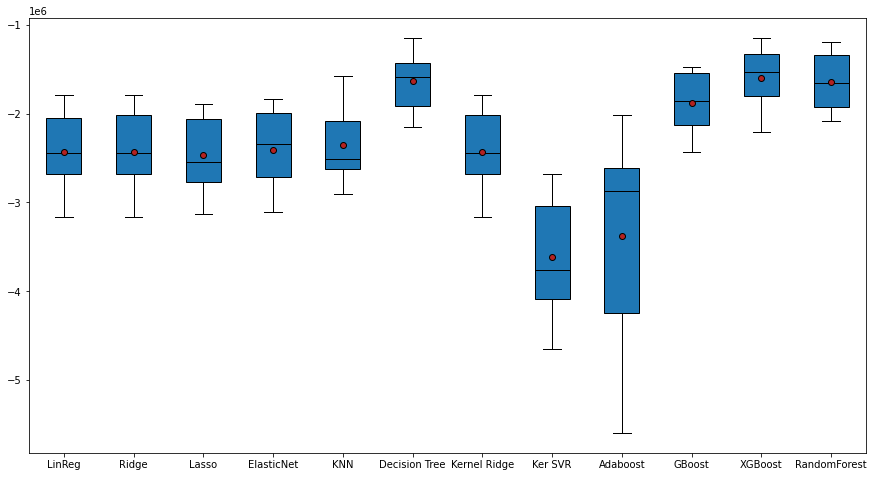

level = 2


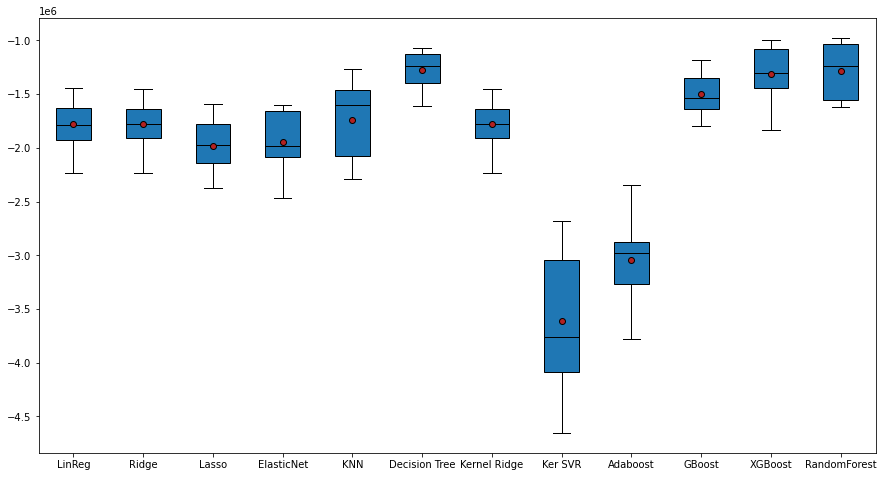

level = 3


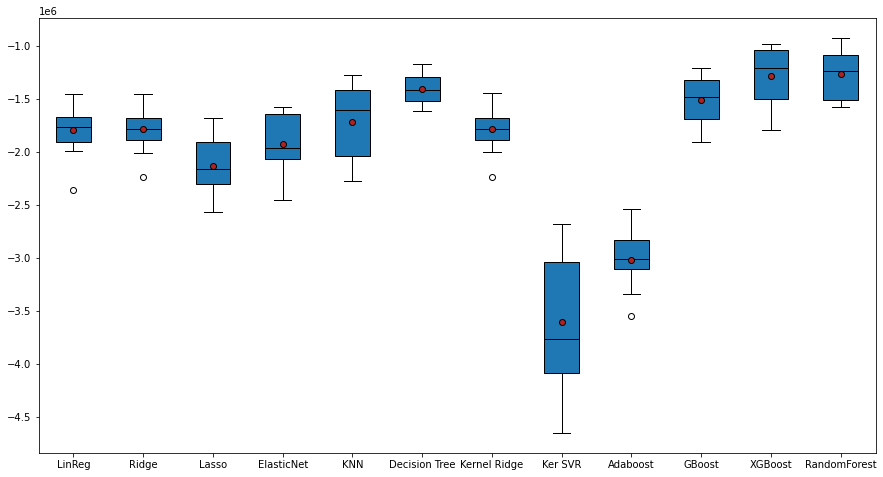

level = all


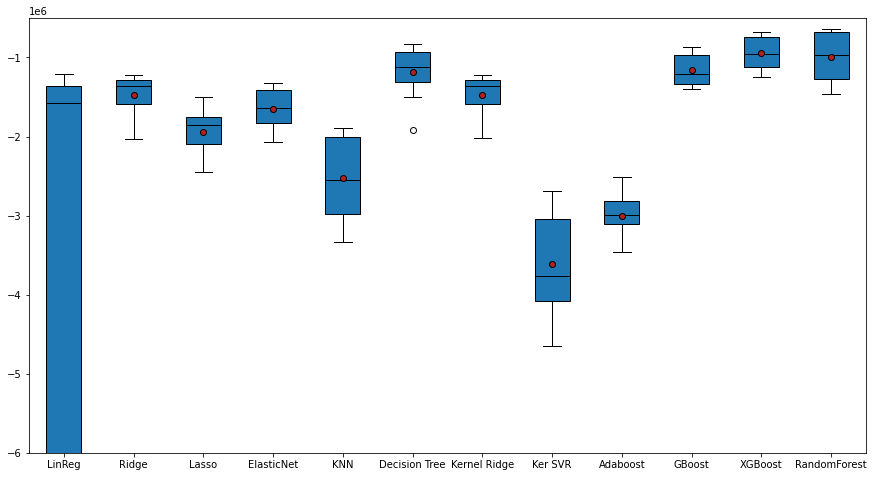

In [22]:
for level in result['level'].unique() : 
    print("="*50)
    print(f"level = {level}")
    print("="*50)
    fig, ax = plt.subplots(figsize=(15,8))
    ax.boxplot(result.loc[(result["level"]==level) & (result["scaler"]=="std")]['result_obj'], labels=names,\
              medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)
    if level == "all" :
        ax.set_ylim(-6e6, -0.5e6)
    #print(result.loc[(result["level"]==level) & (result["scaler"]=="std")])
    plt.show()

les meilleurs performances sont obtenues sur les modèles basés sur des arbres de décisions.  
De manière générale les modèles XGBoost donnent des meilleures performances. On sélectionne donc ce modèle.  
Parmis les autres modèles on sélectionne également l'ElasticNet afin d'étudier le poids de chaque variable.  

#### effet de la normalisation des données
on etudie l'effet de la normalisation sur ces modèles et sur le niveau "all"

In [23]:
result.loc[(result["level"]=="all") & (result["model"]=="ElasticNet")]

,model,scaler,EnergySoreStar,mean_score,std,result_obj,level
111,ElasticNet,no,False,-1.468863e+06,235731.654837,"[-1594962.4229140903, -1913574.5028040484, -12...",all
123,ElasticNet,std,False,-1.648877e+06,249965.608138,"[-2064208.5032852096, -1838478.4650046993, -19...",all
135,ElasticNet,log,False,-3.148358e+06,474895.418517,"[-3769801.7340779244, -3697280.5636495166, -39...",all


Model = XGBoost


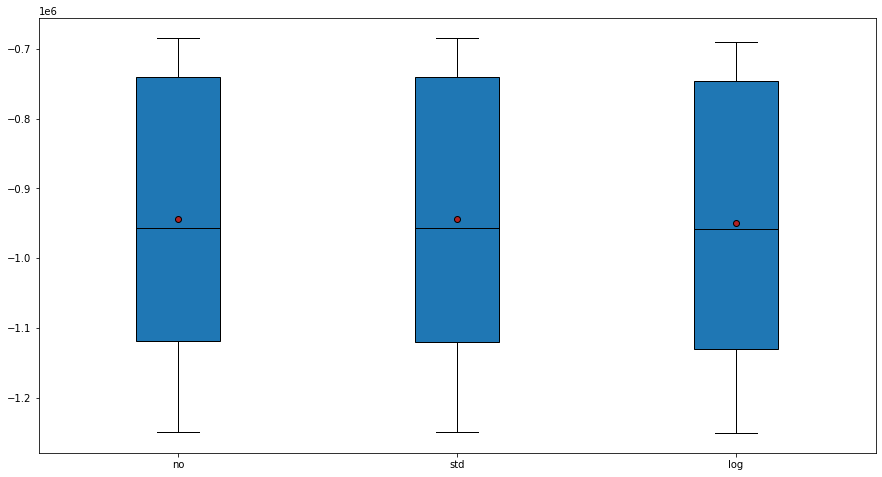

Model = ElasticNet


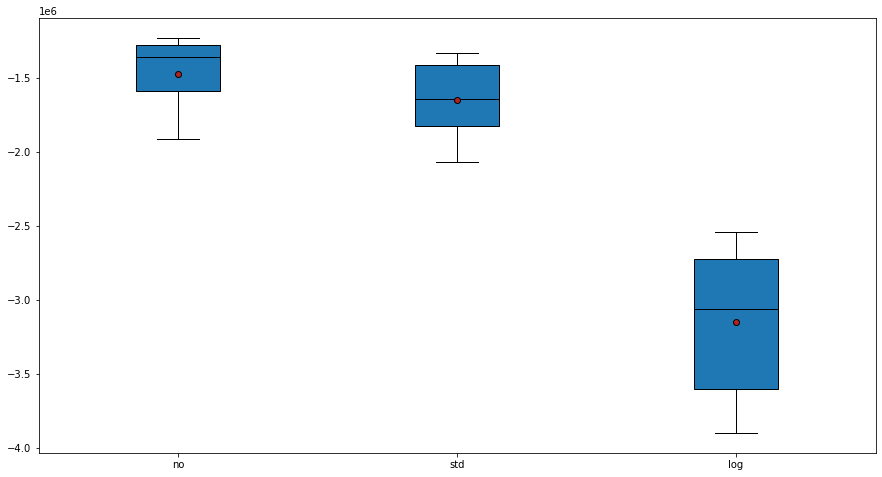

In [24]:
for m in ["XGBoost", "ElasticNet"] :
    print("="*50)
    print(f"Model = {m}")
    print("="*50)
    fig, ax = plt.subplots(figsize=(15,8))
    ax.boxplot(result.loc[(result["level"]=="all") & (result["model"]==m)]['result_obj'], labels=result["scaler"].unique(),\
              medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

Le modele XGBoost est insensible à la normalisation des données.  
Le modèle ElasticNet est plus sensible et donne de meilleur résultat pour des données non normalisées ou centrées réduites.  
Le choix le plus simple est donc de ne pas transformer les données d'entrées.

### Emission de GES

In [25]:
result = result_GES.copy(deep=True)
result[result['level']=="all"]

,model,scaler,EnergySoreStar,mean_score,std,result_obj,level
108,LinReg,no,False,-1.854577e+08,3.712562e+08,"[-855946904.8658223, -794727.8364501145, -2017...",all
109,Ridge,no,False,-4.483682e+01,6.191761e+00,"[-39.94305396532403, -55.84005626006335, -44.2...",all
110,Lasso,no,False,-4.684714e+01,6.265482e+00,"[-42.12655052240385, -56.056019327869684, -47....",all
111,ElasticNet,no,False,-4.471306e+01,5.911722e+00,"[-39.89773184865296, -54.8016327113579, -44.18...",all
112,KNN,no,False,-5.640636e+01,1.189298e+01,"[-54.468527220630385, -82.82028653295129, -65....",all
113,Decision Tree,no,False,-2.742653e+01,9.440704e+00,"[-27.597936962750715, -35.93997134670487, -31....",all
114,Kernel Ridge,no,False,-4.481810e+01,6.173070e+00,"[-39.972664343716424, -55.687208136528476, -44...",all
115,Ker SVR,no,False,-6.586524e+01,1.580371e+01,"[-67.08610592372767, -98.82785511476843, -74.9...",all
116,Adaboost,no,False,-2.037803e+02,2.904304e+01,"[-220.81973967337086, -243.11804073737076, -22...",all
117,GBoost,no,False,-2.768105e+01,7.054552e+00,"[-26.372163168349292, -41.14153318220495, -31....",all


#### avec les données centrées réduites

level = 1


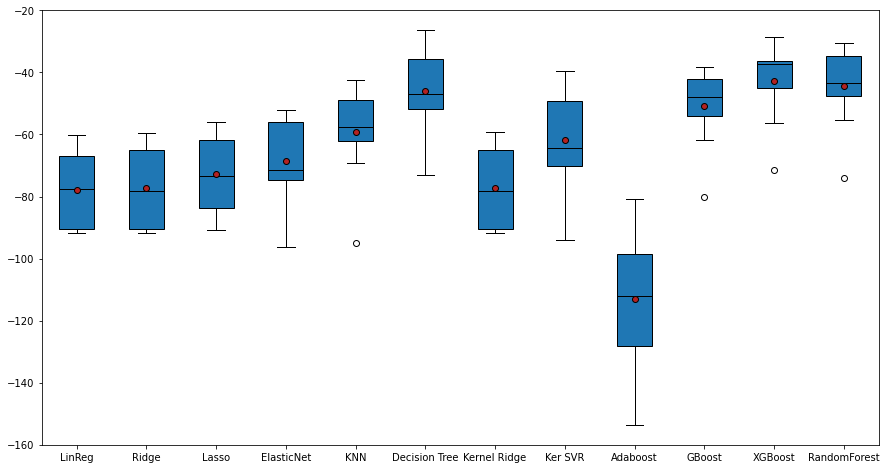

level = 2


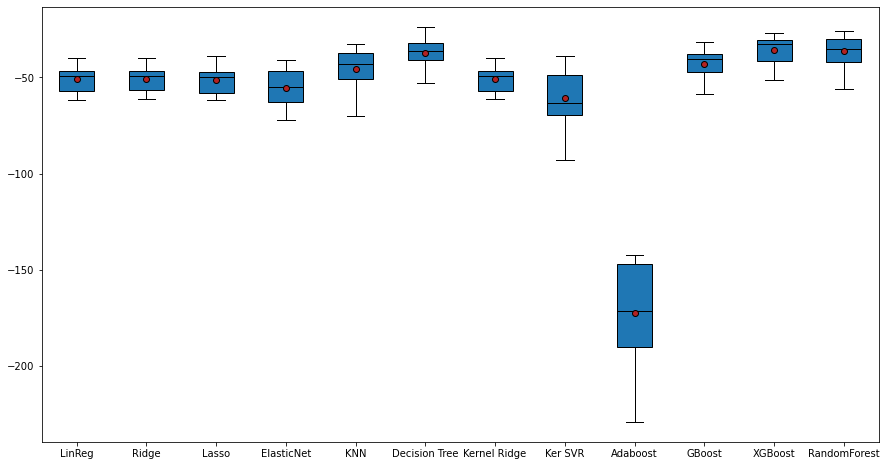

level = 3


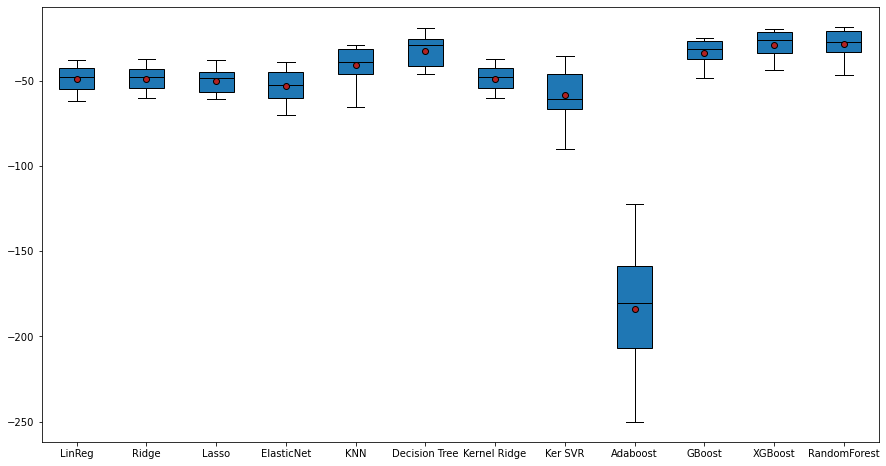

level = all


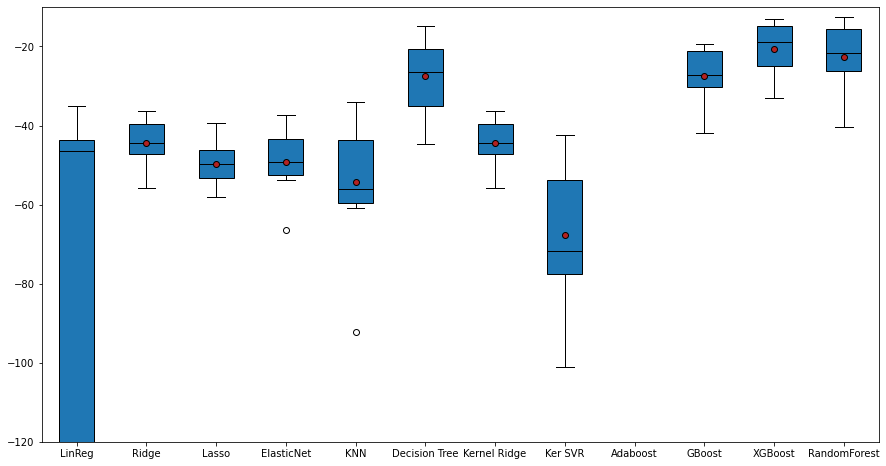

In [26]:
for level in result['level'].unique() : 
    print("="*50)
    print(f"level = {level}")
    print("="*50)
    fig, ax = plt.subplots(figsize=(15,8))
    ax.boxplot(result.loc[(result["level"]==level) & (result["scaler"]=="std")]['result_obj'], labels=names,\
              medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)
    if level == "all" :
        ax.set_ylim(-120, -10)
    #print(result.loc[(result["level"]==level) & (result["scaler"]=="std")])
    plt.show()

Les mêmes observations que pour la consommation d'énergie peuvent être faites.  
Le modèle KNN peut être également performant.  

#### effet de la normalisation des données

Model = XGBoost


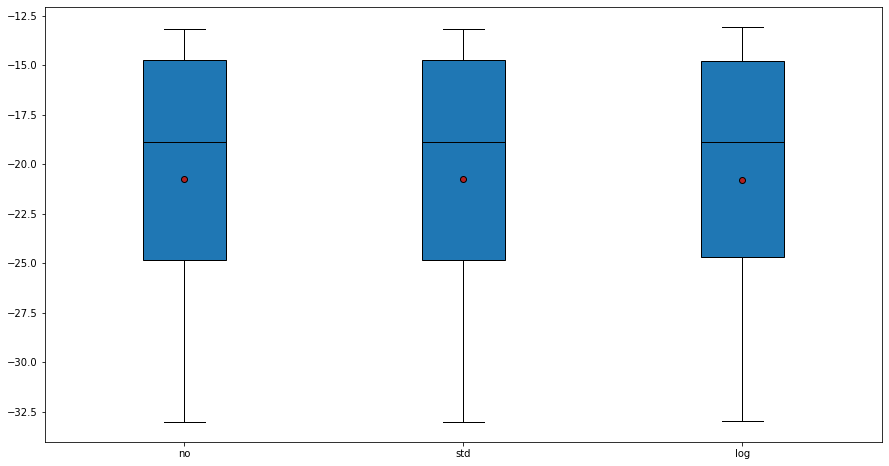

Model = ElasticNet


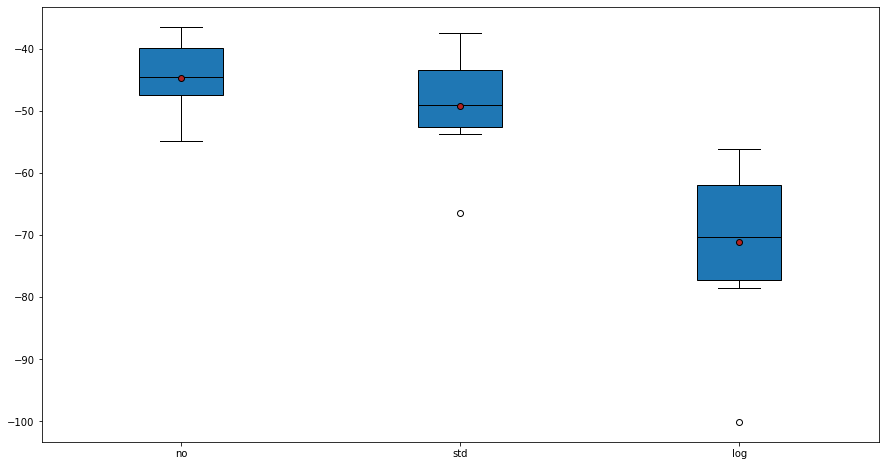

In [27]:
for m in ["XGBoost", "ElasticNet"] :
    print("="*50)
    print(f"Model = {m}")
    print("="*50)
    fig, ax = plt.subplots(figsize=(15,8))
    ax.boxplot(result.loc[(result["level"]=="all") & (result["model"]==m)]['result_obj'], labels=result["scaler"].unique(),\
              medianprops=medianprops, patch_artist=True, showmeans=True, meanprops=meanprops)
    plt.show()

Mêmes observations que pour la consommation d'énergie

## Choix du modèle et la normalisation :
On va donc sélectionner 2 modèles : 
- XGBoost : Méthode ensembliste
- ElasticNet : regression linéaire permettant de discuter du poids de chaque variable

On choisit également de travailler avec des données non normalisées compte tenu du faible gain engendré par la normalisation.

## Tunning des modèles

In [28]:
tunning_result={"NRJ":{}, 'GES':{}}

### ElasticNet
On va optimiser les hyperparamètres du modèle :
- le paramètre alpha : contrôle de la régularisation
- l1_ratio : proportion de la régularisation l1 par rapport à l2

l'optimisation est réalisée sur le level 2

In [29]:
print(f"Score inital pour l'énergy = {result_NRJ.loc[(result_NRJ['model'] == 'ElasticNet') & (result_NRJ['scaler']=='no') & (result_NRJ['level']==2)]['mean_score'].values}")
print(f"Score inital pour l'émission de GES = {result_GES.loc[(result_GES['model'] == 'ElasticNet') & (result_GES['scaler']=='no') & (result_GES['level']==2)]['mean_score'].values}")

Score inital pour l'énergy = [-1763039.42032991]
Score inital pour l'émission de GES = [-51.21580501]


In [30]:
# Chargement des modèles optimisés
if os.path.isfile("best_model_opt.pkl") :
    with open("best_model_opt.pkl", 'rb') as f :
        tunning_result = pickle.load(f)
    print(f"Best result for energy : {tunning_result['NRJ']['ElasticNet'].best_score_:.5e} with {tunning_result['NRJ']['ElasticNet'].best_params_}")
    print(f"Best result for GES : {tunning_result['GES']['ElasticNet'].best_score_} with {tunning_result['GES']['ElasticNet'].best_params_}")
else : # optimisation des hyperparamètres
    x_train = X_train[level2_col]
    param = { "alpha" : np.logspace(-3, 3, 50), "l1_ratio" : np.arange(0,1, 0.1)}
    model_NRJ = linear_model.ElasticNet()
    kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
    grid_NRJ = model_selection.GridSearchCV(estimator=model_NRJ, param_grid=param, scoring=scoring, cv=kfold, n_jobs=n_job)

    #grid_result = grid.fit(x_train, y_train_NRJ)
    model.set_params(max_iter=1000, tol=0.01)
    tunning_result["NRJ"]["ElasticNet"] = grid_NRJ.fit(x_train, y_train_NRJ)
    print(f"Best result for energy : {tunning_result['NRJ']['ElasticNet'].best_score_:.5e} with {tunning_result['NRJ']['ElasticNet'].best_params_}")
    #grid_result = grid.fit(x_train, y_train_GES)
    model_GES = linear_model.ElasticNet()
    model.set_params(max_iter=3000, tol=1e-4)
    grid_GES = model_selection.GridSearchCV(estimator=model_GES, param_grid=param, scoring=scoring, cv=kfold, n_jobs=n_job)
    tunning_result["GES"]["ElasticNet"] = grid_GES.fit(x_train, y_train_GES)
    print(f"Best result for GES : {tunning_result['GES']['ElasticNet'].best_score_} with {tunning_result['GES']['ElasticNet'].best_params_}")

Best result for energy : -1.73311e+06 with {'alpha': 0.21209508879201905, 'l1_ratio': 0.4}
Best result for GES : -49.15237944144475 with {'alpha': 0.868511373751352, 'l1_ratio': 0.9}


### XGBoost
On va optimiser les hyperparamètres du modèle :
- le learning rate : contrôle de la descente de gradient
- max_depth : profondeur de chaque arbre
- subsample : pourcentage d'observations pour chaque arbre
- colsample_bytree : nombre de colonne par arbre
- n_estimators : nombre d'arbre

l'optimisation est réalisée sur le level 2

In [31]:
print(f"Score inital pour l'énergy = {result_NRJ.loc[(result_NRJ['model'] == 'XGBoost') & (result_NRJ['scaler']=='no') & (result_NRJ['level']==2)]['mean_score'].values}")
print(f"Score inital pour l'émission de GES = {result_GES.loc[(result_GES['model'] == 'XGBoost') & (result_GES['scaler']=='no') & (result_GES['level']==2)]['mean_score'].values}")

Score inital pour l'énergy = [-1311411.01914187]
Score inital pour l'émission de GES = [-35.84554589]


In [32]:
if os.path.isfile("best_model_opt.pkl") :
    with open("best_model_opt.pkl", 'rb') as f :
        tunning_result = pickle.load(f)
    print(f"Best result for energy : {tunning_result['NRJ']['XGBoost'].best_score_} with {tunning_result['NRJ']['XGBoost'].best_params_}")
    print(f"Best result for GES : {tunning_result['GES']['XGBoost'].best_score_} with {tunning_result['GES']['XGBoost'].best_params_}")
else :
    x_train = X_train[level2_col]
    param = { "learning_rate" : np.arange(0,0.4, 0.1), 'max_depth': range(1,50,5), "subsample": np.arange(0.6,1.1,0.2), \
         'colsample_bytree': np.arange(0.6,1.1,0.2), "n_estimators" : range(100, 500, 100)}
    model_NRJ = xgb.XGBRegressor()
    kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
    grid_NRJ = model_selection.GridSearchCV(estimator=model_NRJ, param_grid=param, scoring=scoring, cv=kfold, n_jobs=n_job)

    #grid_result = grid.fit(x_train, y_train_NRJ)
    tunning_result["NRJ"]["XGBoost"] = grid_NRJ.fit(x_train, y_train_NRJ)
    print(f"Best result for energy : {tunning_result['NRJ']['XGBoost'].best_score_} with {tunning_result['NRJ']['XGBoost'].best_params_}")
    #grid_result = grid.fit(x_train, y_train_GES)
    model_GES = xgb.XGBRegressor()
    grid_GES = model_selection.GridSearchCV(estimator=model_GES, param_grid=param, scoring=scoring, cv=kfold, n_jobs=n_job)
    tunning_result["GES"]["XGBoost"] = grid_GES.fit(x_train, y_train_GES)
    print(f"Best result for GES : {tunning_result['GES']['XGBoost'].best_score_} with {tunning_result['GES']['XGBoost'].best_params_}")

Best result for energy : -1096725.7916561991 with {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 400, 'subsample': 0.6}
Best result for GES : -31.488770786672177 with {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 21, 'n_estimators': 300, 'subsample': 0.8}


### Sauvegarde des meilleurs modèles

In [33]:
with open("best_model_opt.pkl", 'wb') as ofile :
    pickle.dump(tunning_result, ofile)

## Effet de la variable ENERGYSTARScore
Pour évaluer l'impact de la variable ENERGYSTARScore sur la performance des modèles,  
des apprentissages vont être réalisés sur les deux modèles optimisées et pour chaque groupe de variables.

In [34]:
result_model_opt = pd.DataFrame(columns=["model", "Y", "ENERGYSTARScore","R2", "MAE", "%MAE", "level"])
column = {1:level1_col, 2:level2_col, 3:level3_col, "all":list(X_train.columns)}
column['all'].remove('ENERGYSTARScore')

### Effet sur la prédiction de la consommation d'énergie

In [35]:
print("-"*20)
print("Consommation d'énergie")
print("-"*20)
for level in [1,2,3,"all"] :
    energystarscore = False
    level_col = column[level]
    norm="no"
    x_train = X_train[level_col]
    y_train = y_train_NRJ
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    for name in tunning_result['NRJ']: 
        #print(name)
        model = tunning_result['NRJ'][name].best_estimator_
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        score_result = {}
        for score in ["neg_mean_absolute_error", "r2"] :
            cv_results = model_selection.cross_val_score(model, x_train, y_train, \
                                                         cv=kfold, scoring=score, n_jobs=n_job)
            print(f"{name:15s}: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")
            score_result[score] = cv_results.mean()
        result_model_opt = result_model_opt.append({"model" :name, "Y": "Energy", "ENERGYSTARScore" : energystarscore,\
                                              'R2': score_result['r2'] , 'MAE' : score_result["neg_mean_absolute_error"],\
                                              "level":level}, ignore_index=True)
    
    energystarscore = True
    level_col = column[level]+['ENERGYSTARScore']
    norm="no"
    x_train = X_train[level_col]
    y_train = y_train_NRJ
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    for name in tunning_result['NRJ']: 
        #print(name)
        model = tunning_result['NRJ'][name].best_estimator_
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        score_result = {}
        for score in ["neg_mean_absolute_error", "r2"] :
            cv_results = model_selection.cross_val_score(model, x_train, y_train, \
                                                         cv=kfold, scoring=score, n_jobs=n_job)
            print(f"{name:15s}: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")
            score_result[score] = cv_results.mean()
        result_model_opt = result_model_opt.append({"model" :name, "Y": "Energy", "ENERGYSTARScore" : energystarscore,\
                                              'R2': score_result['r2'] , 'MAE' : score_result["neg_mean_absolute_error"],\
                                              "level":level}, ignore_index=True)

--------------------
Consommation d'énergie
--------------------
Level = 1 ; scaler = no ; EnergyStarScore = False
ElasticNet     : -2417404.809 (449535.659)
ElasticNet     :      0.493 (     0.188)
XGBoost        : -1403054.179 (319684.072)
XGBoost        :      0.746 (     0.188)
Level = 1 ; scaler = no ; EnergyStarScore = True
ElasticNet     : -2507879.579 (430380.586)
ElasticNet     :      0.512 (     0.193)
XGBoost        : -1342850.488 (282234.387)
XGBoost        :      0.748 (     0.156)
Level = 2 ; scaler = no ; EnergyStarScore = False
ElasticNet     : -1733113.759 (228099.034)
ElasticNet     :      0.788 (     0.089)
XGBoost        : -1096725.792 (215260.535)
XGBoost        :      0.857 (     0.106)
Level = 2 ; scaler = no ; EnergyStarScore = True
ElasticNet     : -1764806.848 (202759.500)
ElasticNet     :      0.802 (     0.089)
XGBoost        : -991435.972 (219887.171)
XGBoost        :      0.865 (     0.105)
Level = 3 ; scaler = no ; EnergyStarScore = False
ElasticNet     :

### Effet sur la prédiction de les émissions de GES

In [36]:
print("-"*20)
print("Emissions de GES")
print("-"*20)
for level in [1,2,3,"all"] :
    energystarscore = False
    level_col = column[level]
    norm="no"
    x_train = X_train[level_col]
    y_train = y_train_GES
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    for name in tunning_result['GES']: 
        #print(name)
        model = tunning_result['GES'][name].best_estimator_
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        score_result = {}
        for score in ["neg_mean_absolute_error", "r2"] :
            cv_results = model_selection.cross_val_score(model, x_train, y_train, \
                                                         cv=kfold, scoring=score, n_jobs=n_job)
            print(f"{name:15s}: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")
            score_result[score] = cv_results.mean()
        result_model_opt = result_model_opt.append({"model" :name, "Y": "GES", "ENERGYSTARScore" : energystarscore,\
                                              'R2': score_result['r2'] , 'MAE' : score_result["neg_mean_absolute_error"],\
                                              "level":level}, ignore_index=True)
    
    energystarscore = True
    level_col = column[level]+['ENERGYSTARScore']
    norm="no"
    x_train = X_train[level_col]
    y_train = y_train_GES
    print("="*50)
    print(f"Level = {level} ; scaler = {norm} ; EnergyStarScore = {energystarscore}")
    print("="*50)
    for name in tunning_result['GES']: 
        #print(name)
        model = tunning_result['GES'][name].best_estimator_
        kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
        score_result = {}
        for score in ["neg_mean_absolute_error", "r2"] :
            cv_results = model_selection.cross_val_score(model, x_train, y_train, \
                                                         cv=kfold, scoring=score, n_jobs=n_job)
            print(f"{name:15s}: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")
            score_result[score] = cv_results.mean()
        result_model_opt = result_model_opt.append({"model" :name, "Y": "GES", "ENERGYSTARScore" : energystarscore,\
                                              'R2': score_result['r2'] , 'MAE' : score_result["neg_mean_absolute_error"],\
                                              "level":level}, ignore_index=True)

--------------------
Emissions de GES
--------------------
Level = 1 ; scaler = no ; EnergyStarScore = False
ElasticNet     :    -75.265 (    12.810)
ElasticNet     :      0.099 (     0.355)
XGBoost        :    -36.771 (    12.574)
XGBoost        :      0.664 (     0.218)
Level = 1 ; scaler = no ; EnergyStarScore = True
ElasticNet     :    -82.441 (    10.481)
ElasticNet     :      0.109 (     0.369)
XGBoost        :    -35.244 (    10.997)
XGBoost        :      0.706 (     0.174)
Level = 2 ; scaler = no ; EnergyStarScore = False
ElasticNet     :    -49.152 (     7.369)
ElasticNet     :      0.667 (     0.184)
XGBoost        :    -31.489 (     8.925)
XGBoost        :      0.781 (     0.098)
Level = 2 ; scaler = no ; EnergyStarScore = True
ElasticNet     :    -51.066 (     6.638)
ElasticNet     :      0.676 (     0.173)
XGBoost        :    -29.511 (     7.852)
XGBoost        :      0.807 (     0.116)
Level = 3 ; scaler = no ; EnergyStarScore = False
ElasticNet     :    -48.706 (     7.2

In [37]:
result_model_opt

,model,Y,ENERGYSTARScore,R2,MAE,%MAE,level
0,ElasticNet,Energy,False,0.492872,-2.417405e+06,NaN,1
1,XGBoost,Energy,False,0.745544,-1.403054e+06,NaN,1
2,ElasticNet,Energy,True,0.512283,-2.507880e+06,NaN,1
3,XGBoost,Energy,True,0.748226,-1.342850e+06,NaN,1
4,ElasticNet,Energy,False,0.787775,-1.733114e+06,NaN,2
5,XGBoost,Energy,False,0.856894,-1.096726e+06,NaN,2
6,ElasticNet,Energy,True,0.801702,-1.764807e+06,NaN,2
7,XGBoost,Energy,True,0.864756,-9.914360e+05,NaN,2
8,ElasticNet,Energy,False,0.788036,-1.747036e+06,NaN,3
9,XGBoost,Energy,False,0.858991,-1.090772e+06,NaN,3


## représentation des résultats

### consommation d'énergie

In [38]:
result_model_opt.loc[result_model_opt["Y"]=="Energy"]

,model,Y,ENERGYSTARScore,R2,MAE,%MAE,level
0,ElasticNet,Energy,False,0.492872,-2.417405e+06,NaN,1
1,XGBoost,Energy,False,0.745544,-1.403054e+06,NaN,1
2,ElasticNet,Energy,True,0.512283,-2.507880e+06,NaN,1
3,XGBoost,Energy,True,0.748226,-1.342850e+06,NaN,1
4,ElasticNet,Energy,False,0.787775,-1.733114e+06,NaN,2
5,XGBoost,Energy,False,0.856894,-1.096726e+06,NaN,2
6,ElasticNet,Energy,True,0.801702,-1.764807e+06,NaN,2
7,XGBoost,Energy,True,0.864756,-9.914360e+05,NaN,2
8,ElasticNet,Energy,False,0.788036,-1.747036e+06,NaN,3
9,XGBoost,Energy,False,0.858991,-1.090772e+06,NaN,3


Coefficient de correlation


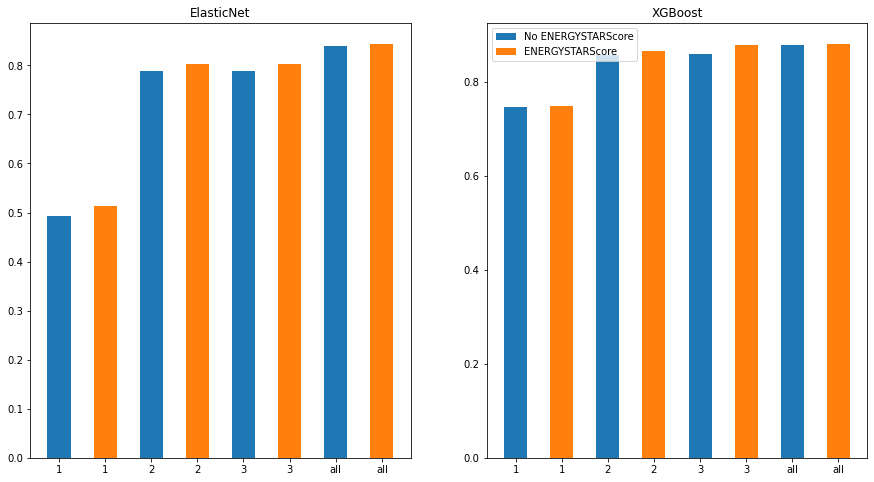

In [39]:
print("="*50)
print("Coefficient de correlation")
print("="*50)
fig,axs = plt.subplots(ncols=2, figsize=(15,8))
for i, model in enumerate(["ElasticNet", 'XGBoost']) :
    dat = result_model_opt.loc[(result_model_opt["Y"]=="Energy") & (result_model_opt["ENERGYSTARScore"] == False ) \
                              & (result_model_opt['model']==model)]
    
    axs[i].bar(range(0,len(dat)*2, 2), dat['R2'], width=0.5, label="No ENERGYSTARScore")
    dat = result_model_opt.loc[(result_model_opt["Y"]=="Energy") & (result_model_opt["ENERGYSTARScore"] == True ) \
                              & (result_model_opt['model']==model)]
    axs[i].bar(range(1,len(dat)*2, 2), dat['R2'], width=0.5, label="ENERGYSTARScore")
    axs[i].set_xticks(range(0,len(dat)*2, 1), minor=False)
    axs[i].set_xticklabels([1,1,2,2,3,3,"all", 'all'])
    axs[i].set_title(model)
plt.legend(loc=0)
plt.show()

Erreur moyenne
Erreur moyenne de la baseline = 4.57733e+06


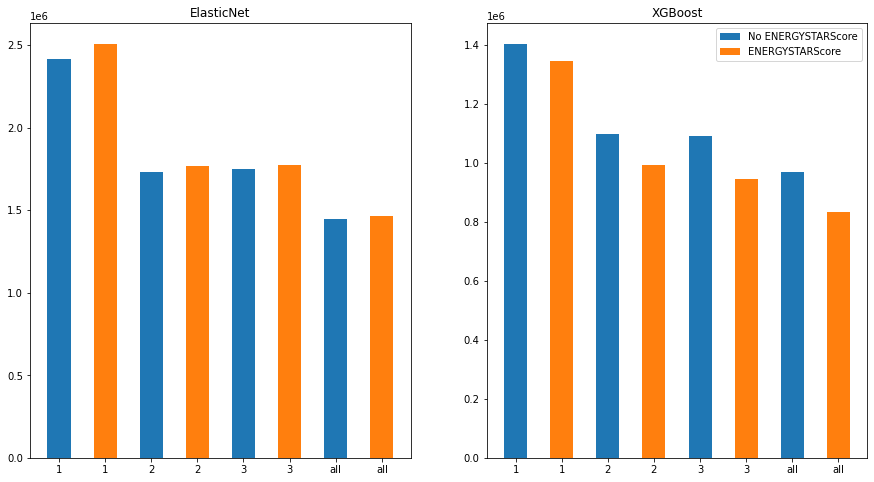

In [40]:
print("="*50)
print("Erreur moyenne")
print("="*50)
print(f"Erreur moyenne de la baseline = {MAE_mean_NRJ:.5e}")
fig,axs = plt.subplots(ncols=2, figsize=(15,8))
for i, model in enumerate(["ElasticNet", 'XGBoost']) :
    dat = result_model_opt.loc[(result_model_opt["Y"]=="Energy") & (result_model_opt["ENERGYSTARScore"] == False ) \
                              & (result_model_opt['model']==model)]
    
    axs[i].bar(range(0,len(dat)*2, 2), -dat['MAE'], width=0.5, label="No ENERGYSTARScore")
    dat = result_model_opt.loc[(result_model_opt["Y"]=="Energy") & (result_model_opt["ENERGYSTARScore"] == True ) \
                              & (result_model_opt['model']==model)]
    axs[i].bar(range(1,len(dat)*2, 2), -dat['MAE'], width=0.5, label="ENERGYSTARScore")
    axs[i].set_xticks(range(0,len(dat)*2, 1), minor=False)
    axs[i].set_xticklabels([1,1,2,2,3,3,"all", 'all'])
    axs[i].set_title(model)
plt.legend(loc=0)
plt.show()

les modèles XGBoost donnent de meilleures performances.  
L'erreur la plus faible est otenue en utilisant l'ensemble des variables disponibles.
Cependant la différence entre le niveau 2 et avec l'ensemble de toutes les données n'est pas très importante et peut donc être un bon compromis entre précision de prédiction et qualité des données.  
    De même le gain obtenu grâce à l'ENERGYSTARScore n'est pas significatif et donc une bonne prédiction peut être réalisée sans.
   

### Emission de GES

In [41]:
result_model_opt.loc[result_model_opt["Y"]=="GES"]

,model,Y,ENERGYSTARScore,R2,MAE,%MAE,level
16,ElasticNet,GES,False,0.098545,-75.264992,NaN,1
17,XGBoost,GES,False,0.663830,-36.770659,NaN,1
18,ElasticNet,GES,True,0.109249,-82.440547,NaN,1
19,XGBoost,GES,True,0.706443,-35.244216,NaN,1
20,ElasticNet,GES,False,0.666571,-49.152379,NaN,2
21,XGBoost,GES,False,0.781135,-31.488771,NaN,2
22,ElasticNet,GES,True,0.676043,-51.065969,NaN,2
23,XGBoost,GES,True,0.807311,-29.510969,NaN,2
24,ElasticNet,GES,False,0.693099,-48.706459,NaN,3
25,XGBoost,GES,False,0.839532,-24.358462,NaN,3


Coefficient de correlation


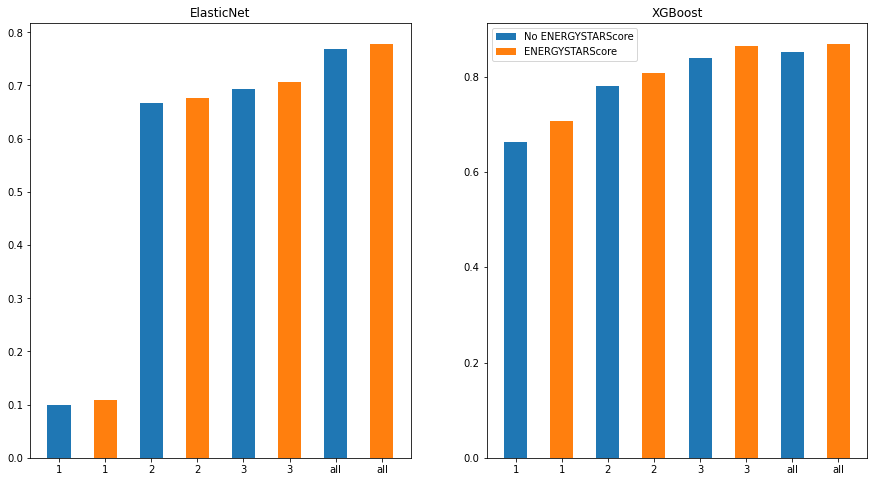

In [42]:
print("="*50)
print("Coefficient de correlation")
print("="*50)
fig,axs = plt.subplots(ncols=2, figsize=(15,8))
for i, model in enumerate(["ElasticNet", 'XGBoost']) :
    dat = result_model_opt.loc[(result_model_opt["Y"]=="GES") & (result_model_opt["ENERGYSTARScore"] == False ) \
                              & (result_model_opt['model']==model)]
    
    axs[i].bar(range(0,len(dat)*2, 2), dat['R2'], width=0.5, label="No ENERGYSTARScore")
    dat = result_model_opt.loc[(result_model_opt["Y"]=="GES") & (result_model_opt["ENERGYSTARScore"] == True ) \
                              & (result_model_opt['model']==model)]
    axs[i].bar(range(1,len(dat)*2, 2), dat['R2'], width=0.5, label="ENERGYSTARScore")
    axs[i].set_xticks(range(0,len(dat)*2, 1), minor=False)
    axs[i].set_xticklabels([1,1,2,2,3,3,"all", 'all'])
    axs[i].set_title(model)
plt.legend(loc=0)
plt.show()

Erreur moyenne
Erreur moyenne de la baseline = 98.86887


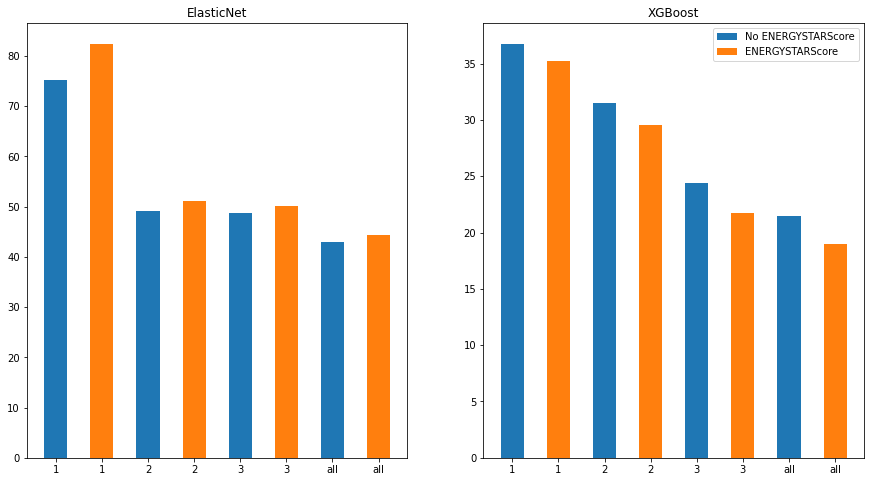

In [43]:
print("="*50)
print("Erreur moyenne")
print("="*50)
print(f"Erreur moyenne de la baseline = {MAE_mean_GES:.5f}")
fig,axs = plt.subplots(ncols=2, figsize=(15,8))
for i, model in enumerate(["ElasticNet", 'XGBoost']) :
    dat = result_model_opt.loc[(result_model_opt["Y"]=="GES") & (result_model_opt["ENERGYSTARScore"] == False ) \
                              & (result_model_opt['model']==model)]
    
    axs[i].bar(range(0,len(dat)*2, 2), -dat['MAE'], width=0.5, label="No ENERGYSTARScore")
    dat = result_model_opt.loc[(result_model_opt["Y"]=="GES") & (result_model_opt["ENERGYSTARScore"] == True ) \
                              & (result_model_opt['model']==model)]
    axs[i].bar(range(1,len(dat)*2, 2), -dat['MAE'], width=0.5, label="ENERGYSTARScore")
    axs[i].set_xticks(range(0,len(dat)*2, 1), minor=False)
    axs[i].set_xticklabels([1,1,2,2,3,3,"all", 'all'])
    axs[i].set_title(model)
plt.legend(loc=0)
plt.show()

Comme pour la consommation d'énergie, le modèle le plus performant est le XGBoost. 
Par contre cette fois plus on ajoute de variables, plus on augmente sensiblement la précision de la prédiction.  
Utiliser la variable ENERGYSTARScore permet d'incoporer moins de variables tout en ayant toujour le même niveau de précision.  

## Précision sur le test set
L'évaluation du test set est effectuée sur l'ensemble des variables puisque cela permet d'obtenir les meilleurs résultats

### Consommation d'énergie

In [44]:
level_col = column["all"]+["ENERGYSTARScore"]
model_NRJ = tunning_result['NRJ']["XGBoost"].best_estimator_
model_NRJ.fit(X_train[level_col], y_train_NRJ)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=16, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
y_pred = model_NRJ.predict(X_test[level_col])
cv_mae = result_model_opt.loc[(result_model_opt['Y']=="Energy") & (result_model_opt["ENERGYSTARScore"] == True ) \
                              & (result_model_opt['model']=="XGBoost") & (result_model_opt["level"]=="all")]["MAE"].values[0]
print(f"Erreur moyenne sur la baseline = {MAE_mean_NRJ:.5e}")
print(f"Erreur moyenne sur la cross validation = {-cv_mae:.5e}")
print(f"Erreur moyenne sur le jeu de train = {metrics.mean_absolute_error(y_train_NRJ, model_NRJ.predict(X_train[level_col])):.5e}")
print(f"Erreur moyenne sur le jeu de test = {metrics.mean_absolute_error(y_test_NRJ, y_pred):.5e}")
#print(f"{name:15s}: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")

Erreur moyenne sur la baseline = 4.57733e+06
Erreur moyenne sur la cross validation = 8.31489e+05
Erreur moyenne sur le jeu de train = 5.25551e+03
Erreur moyenne sur le jeu de test = 7.04893e+05


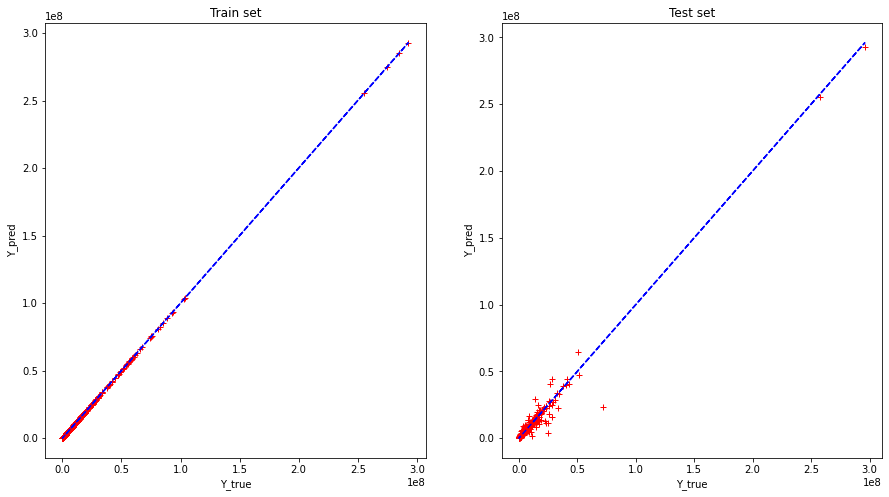

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(15,8))
axs[0].plot(y_train_NRJ, model_NRJ.predict(X_train[level_col]), marker='+', linestyle="", color="red")
axs[0].plot(y_train_NRJ, y_train_NRJ, linestyle="--", color="blue")
axs[0].set_title("Train set")
axs[0].set_xlabel("Y_true")
axs[0].set_ylabel("Y_pred")
axs[1].plot(y_test_NRJ, model_NRJ.predict(X_test[level_col]), marker='+', linestyle="", color="red")
axs[1].plot(y_test_NRJ, y_test_NRJ, linestyle="--", color="blue")
axs[1].set_title("Test set")
axs[1].set_xlabel("Y_true")
axs[1].set_ylabel("Y_pred")
plt.show()

La précision obtenue sur le jeu de test est aussi bon que sur le jeu d'entrainement avec une validation croisée

#### Importance des variables

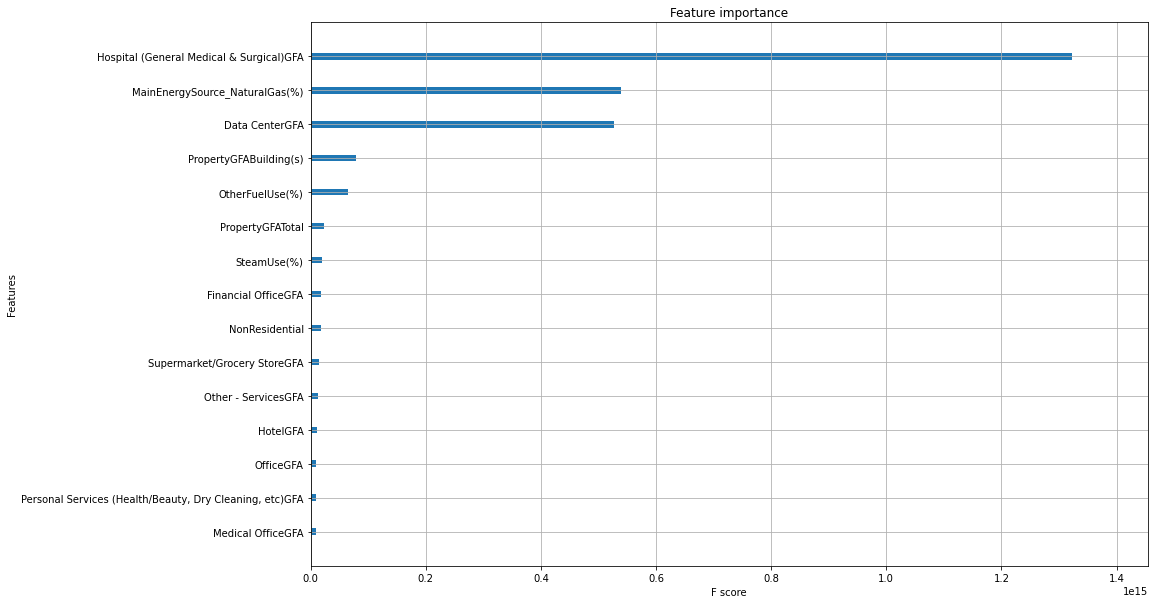

In [47]:
fig, ax = plt.subplots(figsize=(15,10))
xgb.plot_importance(model_NRJ, importance_type="gain", max_num_features=15, show_values=False, ax=ax)
plt.show()

Cette figure permet d'identifier les variables offrant le meilleur gain.   
Il est a noter que l'ENERGYSTARScore n'apparait pas parmi les 20 plus importantes

### Emission de GES

In [48]:
level_col = column["all"]+["ENERGYSTARScore"]
model_GES = tunning_result['GES']["XGBoost"].best_estimator_
model_GES.fit(X_train[level_col], y_train_GES)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=21, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
y_pred = model_GES.predict(X_test[level_col])
cv_mae = result_model_opt.loc[(result_model_opt['Y']=="GES") & (result_model_opt["ENERGYSTARScore"] == True ) \
                              & (result_model_opt['model']=="XGBoost") & (result_model_opt["level"]=="all")]["MAE"].values[0]
print(f"Erreur moyenne sur la baseline = {MAE_mean_GES:.3f}")
print(f"Erreur moyenne sur la cross validation = {-cv_mae:.3f}")
print(f"Erreur moyenne sur le jeu de train = {metrics.mean_absolute_error(y_train_GES, model_GES.predict(X_train[level_col])):.3f}")
print(f"Erreur moyenne sur le jeu de test = {metrics.mean_absolute_error(y_test_GES, y_pred):.3f}")

Erreur moyenne sur la baseline = 98.869
Erreur moyenne sur la cross validation = 19.003
Erreur moyenne sur le jeu de train = 0.012
Erreur moyenne sur le jeu de test = 17.466


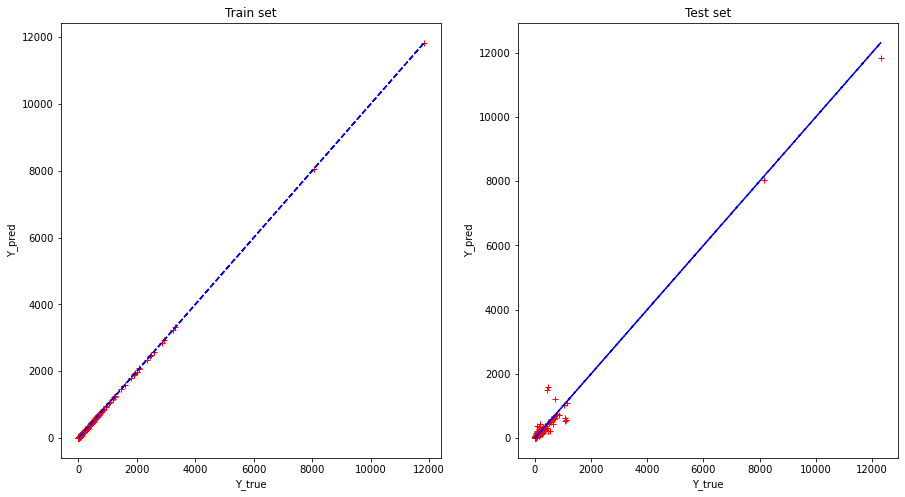

In [50]:
fig, axs = plt.subplots(ncols=2, figsize=(15,8))
axs[0].plot(y_train_GES, model_GES.predict(X_train[level_col]), marker='+', linestyle="", color="red")
axs[0].plot(y_train_GES, y_train_GES, linestyle="--", color="blue")
axs[0].set_title("Train set")
axs[0].set_xlabel("Y_true")
axs[0].set_ylabel("Y_pred")
axs[1].plot(y_test_GES, model_GES.predict(X_test[level_col]), marker='+', linestyle="", color="red")
axs[1].plot(y_test_GES, y_test_GES, linestyle="--", color="blue")
axs[1].set_title("Test set")
axs[1].set_xlabel("Y_true")
axs[1].set_ylabel("Y_pred")
plt.show()

#### Importances des variables

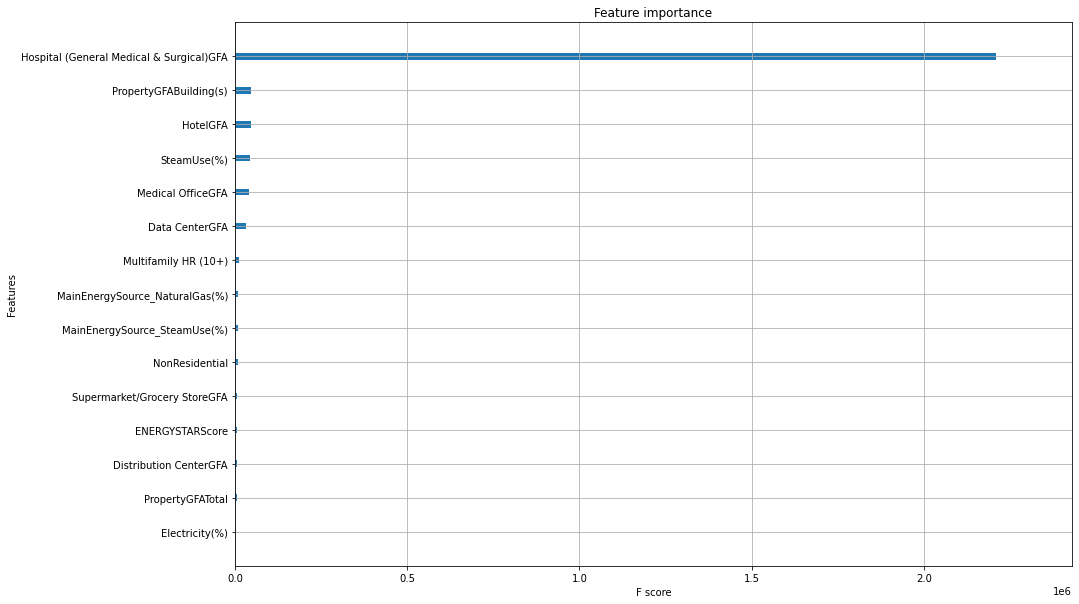

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
xgb.plot_importance(model_GES, importance_type="gain", max_num_features=15, show_values=False, ax=ax)
plt.show()

On remarque cette fois que l'ENERGYSTARScore est présente parmis les 20 variables les plus importantes mais son score reste faible.

## Test avec le second dataset

In [52]:
DATA = pd.read_csv("data/building-energy-benchmarking_cleaned.csv")

In [53]:
Y = DATA[["SiteEnergyUseWN(kBtu)", "GHGEmissions(MetricTonsCO2e)"]]
X = DATA.drop(["SiteEnergyUseWN(kBtu)", "GHGEmissions(MetricTonsCO2e)", 'OSEBuildingID', 'PrimaryPropertyType',\
              'LargestPropertyUseType', 'LargestPropertyUseTypeGFA', 'SteamUse(kBtu)', 'Electricity(kBtu)', \
               'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)' ], axis=1,inplace=False)
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)
y_train_NRJ = Y_train["SiteEnergyUseWN(kBtu)"].values
y_train_GES = Y_train["GHGEmissions(MetricTonsCO2e)"].values
y_test_NRJ = Y_test["SiteEnergyUseWN(kBtu)"].values
y_test_GES = Y_test["GHGEmissions(MetricTonsCO2e)"].values
print(f"Nombre d'observation dans le train set {len(X_train)}")
print(f"Nombre d'observation dans le test set {len(X_test)}")

Nombre d'observation dans le train set 4592
Nombre d'observation dans le test set 1149


### cross validation 
#### Consommation d'énergie

In [54]:
energystarscore = False
level_col = column["all"]
norm="no"
score ="neg_mean_absolute_error"
x_train = X_train[level_col]
y_train = y_train_NRJ
model = tunning_result['NRJ']["XGBoost"].best_estimator_
kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=score, n_jobs=n_job)
print(f"XGBoost sans ENERGYSTARScore: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")

energystarscore = True
level_col = column["all"]+["ENERGYSTARScore"]
norm="no"
score ="neg_mean_absolute_error"
x_train = X_train[level_col]
y_train = y_train_NRJ
model = tunning_result['NRJ']["XGBoost"].best_estimator_
kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=score, n_jobs=n_job)
print(f"XGBoost avec ENERGYSTARScore: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")


XGBoost sans ENERGYSTARScore: -1205363.389 (301548.023)
XGBoost avec ENERGYSTARScore: -1297467.144 (304949.643)


#### Emission de GES

In [55]:
energystarscore = False
level_col = column["all"]
norm="no"
score ="neg_mean_absolute_error"
x_train = X_train[level_col]
y_train = y_train_GES
model = tunning_result['GES']["XGBoost"].best_estimator_
kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=score, n_jobs=n_job)
print(f"XGBoost sans ENERGYSTARScore: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")

energystarscore = True
level_col = column["all"]+["ENERGYSTARScore"]
norm="no"
score ="neg_mean_absolute_error"
x_train = X_train[level_col]
y_train = y_train_GES
model = tunning_result['GES']["XGBoost"].best_estimator_
kfold = model_selection.KFold(n_splits=n_fold, random_state=seed, shuffle=True)
cv_results = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring=score, n_jobs=n_job)
print(f"XGBoost avec ENERGYSTARScore: {cv_results.mean():10.3f} ({cv_results.std():10.3f})")

XGBoost sans ENERGYSTARScore:    -25.335 (     4.216)
XGBoost avec ENERGYSTARScore:    -27.028 (     4.480)


Ajouter plus de données ne permet pas d'améliorer la précision de la prédiction.  
Ce jeu de données est donc suffisant pour prédire la consommation énergétique et les émissions de GES de  l'ensemble des batiments.  
On note également que la méthode d'imputation utilisée ne semble pas adaptée puisque l'utilisation de la variable ENERGYSTARScore dégrade la performance cette fois.

### learning curve
Pour confirmer que le nombre de données dans le premier dataset, nous allons représenter la courbe d'apprentissage 

In [56]:
n_sample, train_score, test_score, *time = model_selection.learning_curve(tunning_result['NRJ']["XGBoost"].best_estimator_, \
                                                                          X_train[level_col], y_train_NRJ,\
                                                                          train_sizes=np.linspace(0.1, 1, 20), \
                                                                          scoring="neg_mean_absolute_error", \
                                                                          random_state=42,\
                                                                          n_jobs=n_job, cv=10, shuffle=True\
                              )

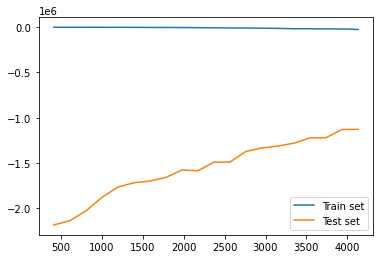

In [57]:
fig, ax = plt.subplots()
ax.plot(n_sample, np.mean(train_score, axis=1), label="Train set")
ax.plot(n_sample, np.mean(test_score, axis=1), label="Test set")
plt.legend()
plt.show()

In [58]:
n_sample, train_score, test_score, *time = model_selection.learning_curve(tunning_result['GES']["XGBoost"].best_estimator_, \
                                                                          X_train[level_col], y_train_GES,\
                                                                          train_sizes=np.linspace(0.1, 1, 20), \
                                                                          scoring="neg_mean_absolute_error", \
                                                                          random_state=42,\
                                                                          n_jobs=n_job, cv=10, shuffle=True\
                              )

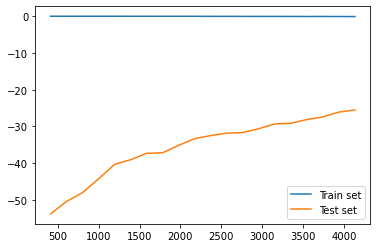

In [59]:
fig, ax = plt.subplots()
ax.plot(n_sample, np.mean(train_score, axis=1), label="Train set")
ax.plot(n_sample, np.mean(test_score, axis=1), label="Test set")
plt.legend()
plt.show()

Les courbes d'apprentissages ne semblent pas avoir atteint le plateur de précision.  
ll semble qu'ajouter plus d'observations permette d'améliorer les performances.  
Il est a noté tout de même que la performance sur le petit dataset et meilleur que sur ce dataset.  
Cela peut être dû au fait que les hyperparamètre ne sont pas optimisés sur ce jeu de données.